In [1]:
# Make plots in the notebook so you can see them.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation as mad
from scipy.optimize import curve_fit
from numpy.random import normal

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# Set up needed methods

def Carter_model(time, tc, f0, delta, T, tau):
    # tc - central transit time
    # f0 - out-of-transit baseline
    # delta - f0*r**2
    # T - 2*tau0*sqrt(1-b**2)
    # tau = 2*tau0*r**2/sqrt(1 - b**2)

    flux = np.zeros_like(time)

    ind = np.abs(time - tc) <= (T/2. - tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta

    ind = ((T/2. - tau/2.) < np.abs(time - tc)) & ((T/2. + tau/2.) > np.abs(time - tc))
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta + (delta/tau)*(np.abs(time[ind] - tc) - T/2. + tau/2.)

    ind = np.abs(time - tc) >= (T/2. + tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0

    return flux

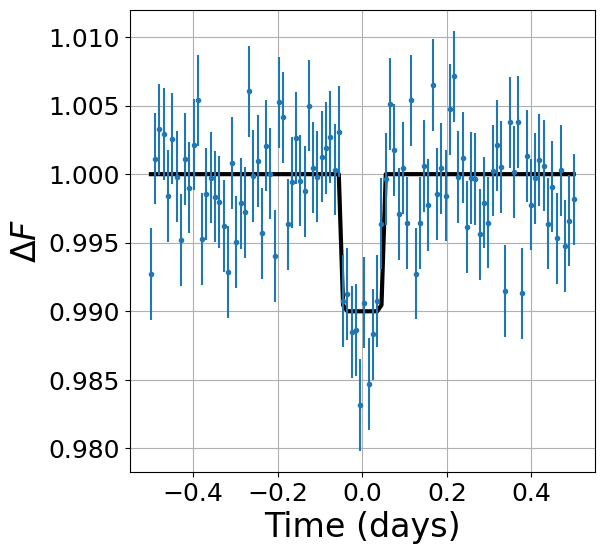

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

period = 1. # arbitrary
tc = 0.
f0 = 1.
delta = 0.01
T = period/10.
tau = T/10.

sigma = delta/3.

num_points = 100
time = np.linspace(-period/2, period/2, num_points)
transit = Carter_model(time, tc, f0, delta, T, tau)

noisy_transit = transit + normal(scale=sigma, size=len(time))

ax.plot(time, transit, lw=3, color='k')
ax.errorbar(time, noisy_transit, yerr=sigma*np.ones_like(time), marker='.', ls='')
ax.set_ylabel(r'$\Delta F$', fontsize=24)
ax.set_xlabel("Time (days)", fontsize=24)
ax.tick_params(labelsize=18)
ax.grid(True)

# fig.savefig("Example_Transit.jpg", dpi=300, bbox_inches="tight")

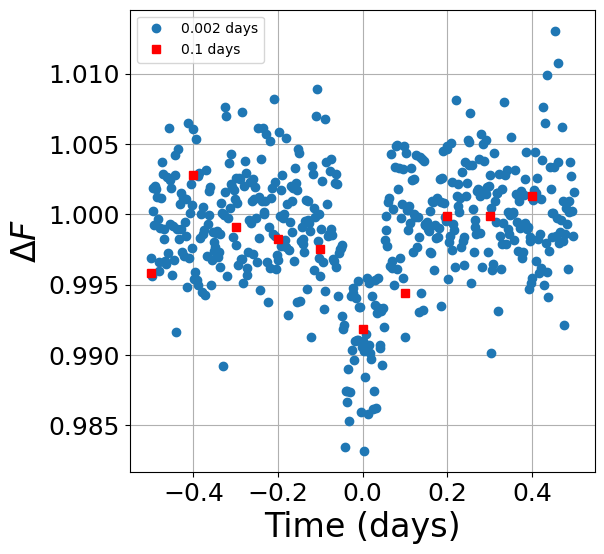

In [39]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

num_points = 20
sampling_rates = np.array([1/500, 1/10])*period

time = np.arange(-period/2, period/2, sampling_rates[0])
transit = Carter_model(time, tc, f0, delta, T, tau)
noisy_transit = transit + normal(scale=sigma, size=len(time))
ax.errorbar(time, noisy_transit, marker='o', ls='', label='%g days' % sampling_rates[0])

time = np.arange(-period/2, period/2, sampling_rates[1])
transit = Carter_model(time, tc, f0, delta, T, tau)
noisy_transit = transit + normal(scale=sigma, size=len(time))
ax.errorbar(time, noisy_transit, marker='s', ls='', color='red', label='%g days' % sampling_rates[1])

ax.set_ylabel(r'$\Delta F$', fontsize=24)
ax.set_xlabel("Time (days)", fontsize=24)
ax.tick_params(labelsize=18)
ax.grid(True)
ax.legend(loc='best')

# fig.savefig("Sampling_Rate_Example.jpg", dpi=300, bbox_inches="tight")

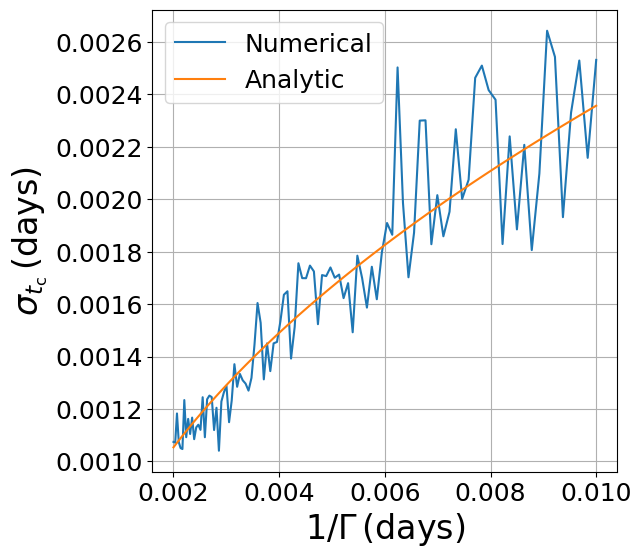

In [9]:
num_points = 100
sampling_rates = 10.**np.linspace(np.log10(1./500), -2., num_points)*period

saved_unc = np.zeros_like(sampling_rates)
for i in range(len(sampling_rates)):
    time = np.arange(-period/2, period/2, sampling_rates[i])
    
    transit = Carter_model(time, tc, f0, delta, T, tau)
    noisy_transit = transit + normal(scale=sigma, size=len(time))
    
    popt, pcov = curve_fit(lambda time, cur_tc: Carter_model(time, cur_tc, f0, delta, T, tau), 
                           time, noisy_transit, sigma=sigma*np.ones_like(time), 
                           p0=[0.])
    unc = np.sqrt(np.diag(pcov))
    if(np.isfinite(unc)):
        saved_unc[i] = unc

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(sampling_rates, saved_unc, label='Numerical')
ax.plot(sampling_rates, np.sqrt(tau/2*sampling_rates)*sigma/delta, label="Analytic")

ax.set_xlabel(r'$1/\Gamma\,\left( {\rm days} \right)$', fontsize=24)
ax.set_ylabel(r'$\sigma_{t_{\rm c}}\,\left( {\rm days} \right)$', fontsize=24)
ax.tick_params(labelsize=18)
ax.grid(True)
ax.legend(loc='best', fontsize=18)

# fig.savefig("sigma_tc_vs_sampling.jpg", dpi=300, bbox_inches="tight")

$$
S_{xx} = \sum_{i=0}^{N-1} \frac{x_i x_i}{\sigma_i^2}
$$

$$
y(x_i) = a + bx_i + cx_i^2
$$